In [16]:
import os
import librosa
import torchaudio
import torchaudio.transforms as T
import random
from torch.utils.data import Dataset
from IPython.display import Audio, display

class MyDataset_self_supervised(Dataset):
    def __init__(self, data_folder, transform=None):
        self.data_folder = data_folder
        self.file_paths = [os.path.join(data_folder, fname) for fname in os.listdir(data_folder) if fname.endswith('.wav')]
        self.transform = transform
    
    def __len__(self):
        return len(self.file_paths)
    
    def random_augmentation(self, waveform):
        # Define three sample augmentations using torchaudio
        augmentations = [
            lambda x: T.Vol(0.5)(x),
            lambda x: self.resample_waveform(x),
            lambda x: T.FrequencyMasking(freq_mask_param=10)(x)
        ]
        return random.choice(augmentations)(waveform)

    def resample_waveform(self, waveform):
        # Modify the speed of the audio waveform
        sample_rate = 44100  # assuming the sample rate is 44100, adjust if different
        new_sample_rate = int(sample_rate * random.uniform(0.8, 1.2))
        resampler = T.Resample(orig_freq=sample_rate, new_freq=new_sample_rate)
        return resampler(waveform)
        
        # Apply TimeStretch
        stretcher = T.TimeStretch(n_freq=201)
        return stretcher(stretched_waveform)

    def __getitem__(self, idx):
        file_path = self.file_paths[idx]
        waveform, sample_rate = librosa.load(file_path, sr=None)
        waveform = torch.tensor(waveform).float().unsqueeze(0)  # Convert to tensor and add channel dimension
        
        # Create Mel Spectrogram
        melspec = T.MelSpectrogram()(waveform)
        
        # Generate a positive example with 3 augmentations
        pos_ex = waveform
        for _ in range(3):
            pos_ex = self.random_augmentation(pos_ex)
        pos_melspec = T.MelSpectrogram()(pos_ex)

        # Generate a negative example with 3 augmentations
        neg_idx = random.choice([i for i in range(len(self.file_paths)) if i != idx])
        neg_waveform, _ = librosa.load(self.file_paths[neg_idx], sr=None)
        neg_waveform = torch.tensor(neg_waveform).float().unsqueeze(0)  # Convert to tensor and add channel dimension
        for _ in range(3):
            neg_waveform = self.random_augmentation(neg_waveform)
        neg_melspec = T.MelSpectrogram()(neg_waveform)
        
        return melspec, pos_melspec, neg_melspec, file_path


In [17]:
MyDataset_self_supervised("./data/ESC50/ESC-50-master/audio/")

In [18]:
import torch.nn as nn

class AudioContrastiveModel(nn.Module):
    def __init__(self):
        super(AudioContrastiveModel, self).__init__()
        
        self.conv_layers = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 128, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2)
        )
        
        self.fc_layers = nn.Sequential(
            nn.Linear(128 * 16 * 16, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 64)
        )
        
    def forward(self, x):
        x = self.conv_layers(x)
        x = x.view(x.size(0), -1)
        x = self.fc_layers(x)
        return x

In [19]:
class ContrastiveLoss(nn.Module):
    def __init__(self, margin=0.5):
        super(ContrastiveLoss, self).__init__()
        self.margin = margin

    def forward(self, anchor, positive, negative):
        pos_distance = (anchor - positive).pow(2).sum(1)
        neg_distance = (anchor - negative).pow(2).sum(1)
        loss = torch.mean(pos_distance + torch.clamp(self.margin - neg_distance, min=0.0))
        return loss

c:\Users\Gabriel\anaconda3\envs\pytorch\Lib\site-packages\torchaudio\functional\functional.py:576: UserWarning: At least one mel filterbank has all zero values. The value for `n_mels` (128) may be set too high. Or, the value for `n_freqs` (201) may be set too low.
  warnings.warn(


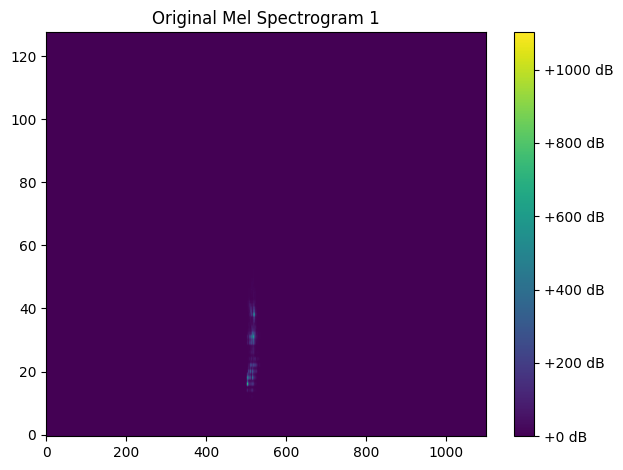

Original Audio:


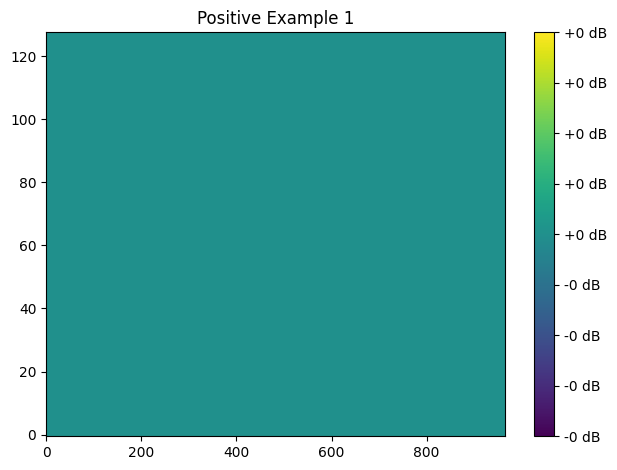

Positive Example Audio:


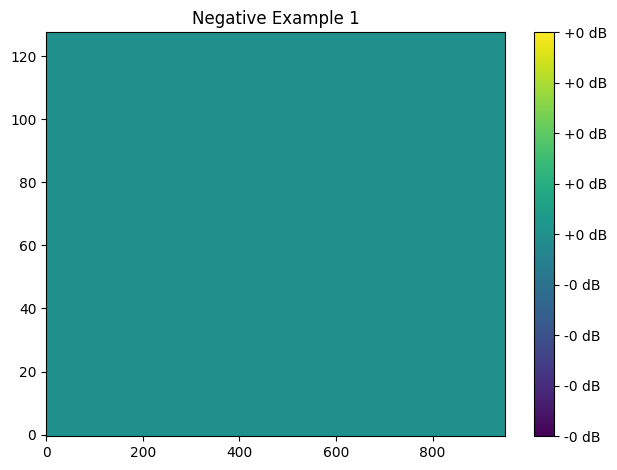

Negative Example Audio:


In [20]:
import matplotlib.pyplot as plt
import torch 

# Initialize the dataset
data_folder = "./data/ESC50/ESC-50-master/audio/"
dataset = MyDataset_self_supervised(data_folder)

def plot_melspectrogram(melspec, title):
    plt.imshow(melspec.squeeze().numpy(), cmap='viridis', origin='lower', aspect='auto')
    plt.colorbar(format='%+2.0f dB')
    plt.title(title)
    plt.tight_layout()
    plt.show()

# Visualize the first few pairs
num_pairs_to_show = 2

def play_audio(waveform, sample_rate=44100):
    # Assuming the waveform tensor is (num_channels, num_frames)
    if waveform.shape[0] == 2:  # If stereo, convert it to mono
        waveform = torch.mean(waveform, dim=0, keepdim=True)
    audio = Audio(waveform.numpy(), rate=sample_rate)
    display(audio)

for i in range(num_pairs_to_show):
    melspec, pos_melspec, neg_melspec, file_path = dataset[i]
    
    # Load original waveform for playback
    waveform, _ = torchaudio.load(file_path, num_frames=5*44100)
    
    # Original Mel Spectrogram
    plot_melspectrogram(melspec, title=f"Original Mel Spectrogram {i + 1}")
    print("Original Audio:")
    play_audio(waveform)
    
    # Since the augmented waveforms aren't directly returned by the dataset, 
    # I'm just playing the original audio for the positive and negative examples. 
    # If you want to play the augmented audio, you'd need to modify the dataset 
    # to return the augmented waveforms or reproduce the augmentations here.

    # Positive Example Mel Spectrogram
    plot_melspectrogram(pos_melspec, title=f"Positive Example {i + 1}")
    print("Positive Example Audio:")
    play_audio(waveform)  # Replace with augmented waveform if available
    
    # Negative Example Mel Spectrogram
    plot_melspectrogram(neg_melspec, title=f"Negative Example {i + 1}")
    print("Negative Example Audio:")
    play_audio(waveform)  # Replace with augmented waveform if available


3

# LOG
So lets start from the beginning: I want to create a self supervised contrastive learning approach with the ETC50 Audio Dataset. The Data should be read in a Class MyDataset_self_supervised. In this class for every wav data should be created a mel spectrogram and a negative and a positive example with at least 3 augumentations. The Model should be a deep learning NN that can learn the representations of the audio data.

Change: class MyDataset_self_supervised the ESC50 Audio data points are in a folder and ged rid of the torchaudio.datasets.ESC50